# 1. Preparing our data

## 1.1 Description of the raw data

Our raw data is given in the form of three vectors:

* x: energy
* y: number of photons
* y_err: error in y, which should be in our case equal to $\sqrt{y}$

These vectors are placed in the file corresponding to that spectrum, for example

|    X,eV     |   Y      | Y err    |
|----------|----------|----------|
| 6025.88  | 588.0    | 24.25    |
| 6063.11  | 637.0    | 25.24    |
| 6100.57  | 651.0    | 25.51    |
| 6138.25  | 580.0    | 24.08    |
| 6176.17  | 676.0    | 26.0     |
| 6214.33  | 768.0    | 27.71    |

## 1.2 Lower the number of channels

Our spectra are given in the energy range $\left[100,300k\right]$ eV. But we are interested mostly on ~ $\left[1,50\right]$ keV. In addition, we want to reduce the number of channels (energy-bins) because it will have a negative impact on the performance of the DL (Deep Learning) model. There are different ways to achieve this, and we can change this later, therefore now we will simply average neighbor energy bins. This will also help us to smoothen a little bit the spectra. 


The number of channels in the energy distribution is 159


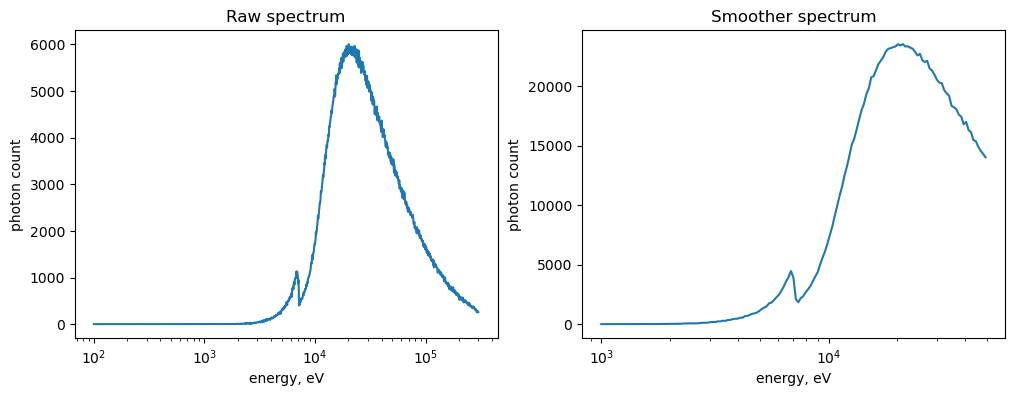

In [1]:
from one_time_utilities import *

x_raw, y_raw, _ = x_y_z(path=".dummydata/224_-1_1xfe_6070_51_8.9e+20_1.1e+26_33_CONTINUUM_NONE.spectrum")

x_smooth,y_smooth = reduce_energy_bins_number(x_raw,y_raw,times_=2)
x_clipped, y_clipped = clip_spectrum(x_smooth,y_smooth,energy_left=1e3,energy_right=50e3)

plot_pair_spectra(x_raw,y_raw,x_clipped,y_clipped,title_left="Raw spectrum",title_right="Smoother spectrum")

print(f"The number of channels in the energy distribution is {len(x_clipped)}")

## 1.3 Normalization

In order to pass our data into the DL model we will normalize the spectra with the given formula (see: https://arxiv.org/abs/2206.04602):

$$
y = \frac{y_{count} - \overline{y_{count}}}{\sigma (y_{count})}
$$

By using the pevious formula, all our spectra will have the same mean value of $0$, and the same standard deviation of $1$.

Later we will pass that normalized $y$ to our DL model.

Mean value: 0.00,    Stdev: 1.00


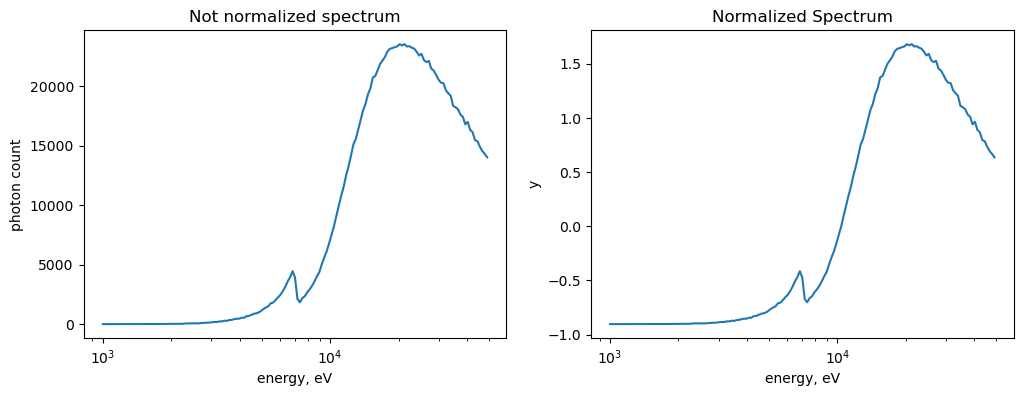

In [2]:
x_normalized, y_normalized = normalize_spectrum(x_clipped,y_clipped)

plot_pair_spectra(x_clipped,y_clipped,
                  x_normalized,y_normalized,
                  title_left="Not normalized spectrum", 
                  title_right="Normalized Spectrum", 
                  y_label_right="y")

print(f"Mean value: {np.mean(y_normalized):.2f},    Stdev: {np.std(y_normalized):0.2f}")

## 1.4 Finishing the preparation of the spectra

Now we can combine the previous operations in a single function.

Mean value: 0.00,    Stdev: 1.00


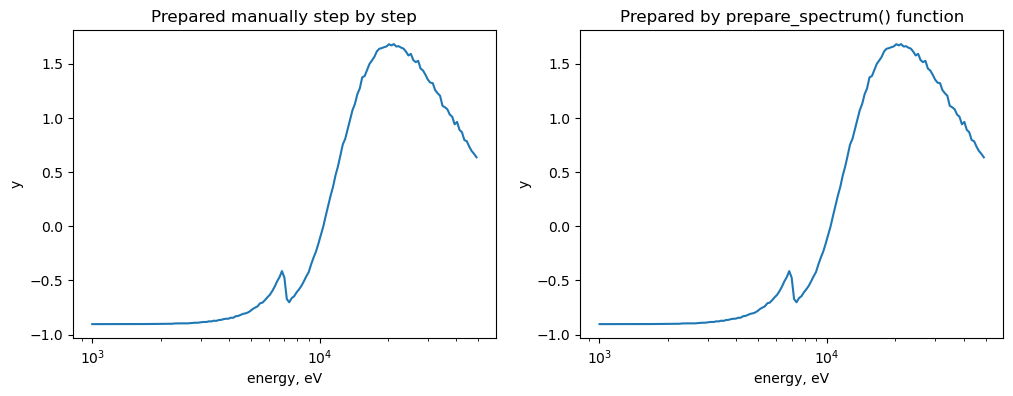

In [3]:
x_prepared, y_prepared = prepare_spectrum(x_raw=x_raw,y_raw=y_raw,energy_left=1e3, energy_right=50e3, squeezin_factor=2)

# Let's compare both retults, we expect them to be equal
plot_pair_spectra(x_normalized,y_normalized,
                  x_prepared,y_prepared,
                  title_left="Prepared manually step by step", 
                  title_right="Prepared by prepare_spectrum() function", 
                  y_label_right="y",y_label_left="y")

print(f"Mean value: {np.mean(y_normalized):.2f},    Stdev: {np.std(y_normalized):0.2f}")

## 1.4 TODO: EXTRACT LABEL DATA FROM THE SPECTRUM

We need now to extract the label data from the spectrum file.